In [87]:
## Deep learning approach using neural networks and pytorch

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
import torch
import torch.nn as nn
from numpy import vstack
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import Adam
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.nn.init import uniform_
from torch.nn.init import normal_
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [90]:
class create_dataset_pca(Dataset):
    #loading the dataset
    def __init__(self,train_df):
        self.train_df = train_df
        self.features = ['mean_sd_integrated','skew_exkurt_integrated','mean_sd_dmsnr','skew_exkurt_dmsnr']
        #self.x=train_df.values[:,:-1].astype('float32')
        #self.y=train_df.values[:,-1]
        
    def preprocess(self,train_df):
        #pre-processing for integrated data
        train_df['mean_sd_integrated'] = train_df['Mean of the integrated profile'] + 3*train_df['Standard deviation of the integrated profile']
        train_df['skew_exkurt_integrated'] = train_df['Skewness of the integrated profile']+train_df['Excess kurtosis of the integrated profile']
        train_df.drop(['Mean of the integrated profile','Standard deviation of the integrated profile','Skewness of the integrated profile','Excess kurtosis of the integrated profile'],axis=1,inplace = True)
        #pre-processing for DM-SNR data
        train_df['mean_sd_dmsnr'] = train_df['Mean of the DM-SNR curve'] + 3*train_df['Standard deviation of the DM-SNR curve']
        train_df['skew_exkurt_dmsnr'] = train_df['Skewness of the DM-SNR curve']+train_df['Excess kurtosis of the DM-SNR curve']
        train_df.drop(['Mean of the DM-SNR curve','Standard deviation of the DM-SNR curve','Skewness of the DM-SNR curve','Excess kurtosis of the DM-SNR curve'],axis=1,inplace = True)
        x = train_df.loc[:, self.features].values
        y = train_df.loc[:,['target_class']].values
        y=y.reshape(len(y),1)
        x=self.apply_standardscaler(train_df)
        return x,y
    def apply_standardscaler(self,train_df):
        df=train_df
        features = ['mean_sd_integrated','skew_exkurt_integrated','mean_sd_dmsnr','skew_exkurt_dmsnr']
        X = df.loc[:, features].values
        X = StandardScaler().fit_transform(X)
        X = X.astype('float32')
        return X
    def apply_pca(self,n_components,X):
        pca = PCA(n_components)
        principalComponents = pca.fit_transform(X)
        principalDf = pd.DataFrame(data = principalComponents
                     , columns = ['pc1','pc2','pc3'])
        X=principalDf.values[:]
        return X
        

In [91]:
#data loaders
class trainData(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
    def __getitem__(self,index):
        return self.x_data[index] , self.y_data[index]
    def __len__(self):
        return len(self.x_data)
        
class testData(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
    def __getitem__(self,index):
        return self.x_data[index] , self.y_data[index]
    def __len__(self):
        return len(self.x_data)
    


In [92]:
def check_pca_comp(x):
    #code for choosing the cumulative variance explained vs number of principal components. 
    from sklearn.decomposition import PCA
    pca_test = PCA().fit(x)
    plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    #pca = PCA(.96)
    #pca.fit(x)
    #pca.n_components_

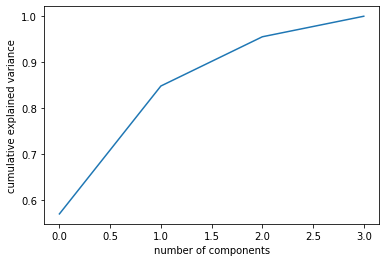

In [93]:
##creation of the dataset
train_load=pd.read_excel('../input/pulsarml/Training_PulsarStars.xlsx')
train_load.to_csv('Training_PulsarStars.csv',index=None,header=True)
dataset = create_dataset_pca(train_load)
x,y = dataset.preprocess(train_load)
##check to choose the number of components to be used in pca.
check_pca_comp(x)
num_comp_pca = 3
X = dataset.apply_pca(num_comp_pca,x)
##test_train split for data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2,random_state=42)

In [94]:
train_load.head()

,target_class,mean_sd_integrated,skew_exkurt_integrated,mean_sd_dmsnr,skew_exkurt_dmsnr
0,0,307.613846,-0.934220,60.531112,82.217757
1,0,279.155103,-0.049770,46.257695,137.970066
2,0,221.040573,1.374493,68.355244,70.907731
3,0,308.285346,-0.704653,66.520817,60.490160
4,0,210.743239,1.724358,35.585089,266.836879


In [95]:
train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
##setting the requirements
BATCH_SIZE = 32
#creating the dataloader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1,shuffle =False)

In [96]:
#Defining our model

In [97]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

In [98]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs):
        super(NeuralNet, self).__init__()
        self.hidden1 = Linear(n_inputs, 32)
        normal_(self.hidden1.weight)
        self.act1 = ReLU()
        self.drop1 = nn.Dropout(p=0.1)
        self.hidden2 = Linear(32, 16)
        normal_(self.hidden2.weight)
        self.act2 = ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        self.hidden3 = Linear(16, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.drop1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.drop2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [99]:
def train_model(train_dl, model,epoch_num):
    criterion = BCELoss()
    optimizer = Adam(model.parameters(), lr=0.03)
    for epoch in range(epoch_num):
        epoch_loss=0
        for i, (inputs, targets) in enumerate(train_loader):
            #inputs = inputs.to(device)
            #targets = targets.to(device)
            optimizer.zero_grad()
            y_fit = model(inputs)
            loss = criterion(y_fit, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+0:03}: | Loss:{epoch_loss/len(train_loader):.5f}')    

In [100]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        #inputs = inputs.to(device)
        #targets = targets.to(device)
        y_fit = model(inputs)
        y_fit = y_fit.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        y_fit = y_fit.round()
        predictions.append(y_fit)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

In [101]:
EPOCH=24
model = NeuralNet(num_comp_pca)
#model.to(device)
train_model(train_loader,model,EPOCH)

Epoch 000: | Loss:0.32013
Epoch 001: | Loss:0.13221
Epoch 002: | Loss:0.13184
Epoch 003: | Loss:0.12791
Epoch 004: | Loss:0.12474
Epoch 005: | Loss:0.13465
Epoch 006: | Loss:0.12892
Epoch 007: | Loss:0.12859
Epoch 008: | Loss:0.12581
Epoch 009: | Loss:0.13599
Epoch 010: | Loss:0.13727
Epoch 011: | Loss:0.12679
Epoch 012: | Loss:0.12758
Epoch 013: | Loss:0.12976
Epoch 014: | Loss:0.12667
Epoch 015: | Loss:0.12906
Epoch 016: | Loss:0.13654
Epoch 017: | Loss:0.12522
Epoch 018: | Loss:0.12739
Epoch 019: | Loss:0.12672
Epoch 020: | Loss:0.12645
Epoch 021: | Loss:0.13967
Epoch 022: | Loss:0.13581
Epoch 023: | Loss:0.12734


In [102]:
#evaluate_model(test_loader, model)
acc = evaluate_model(test_loader, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.955
